# Import Library

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from xgboost import XGBClassifier
from sklearn.svm import SVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,  RandomForestClassifier, HistGradientBoostingRegressor


# Load Data

In [2]:
data = pd.read_csv("..\Dataset\HepatitisCdata.csv").drop(columns=['Unnamed: 0'])
data.sample(5)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
521,0=Blood Donor,61,f,43.4,47.5,12.8,17.3,5.6,7.52,5.81,71.0,11.8,69.9
611,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
495,0=Blood Donor,56,f,33.2,54.3,15.5,22.8,8.0,5.61,3.87,55.0,19.1,63.1
290,0=Blood Donor,63,m,39.5,59.6,26.2,25.4,12.4,6.78,6.18,78.0,22.6,72.7
175,0=Blood Donor,48,m,46.2,59.9,14.6,25.7,5.3,6.93,6.29,66.0,23.4,75.8


# Inital Analysis

In [2]:
print(data.info())

NameError: name 'data' is not defined

In [9]:
round(data.describe().transpose(), 2)

,count,mean,std,min,25%,50%,75%,max
Age,615.0,47.41,10.06,19.00,39.00,47.00,54.00,77.00
ALB,614.0,41.62,5.78,14.90,38.80,41.95,45.20,82.20
ALP,597.0,68.28,26.03,11.30,52.50,66.20,80.10,416.60
ALT,614.0,28.45,25.47,0.90,16.40,23.00,33.08,325.30
AST,615.0,34.79,33.09,10.60,21.60,25.90,32.90,324.00
BIL,615.0,11.40,19.67,0.80,5.30,7.30,11.20,254.00
CHE,615.0,8.20,2.21,1.42,6.94,8.26,9.59,16.41
CHOL,605.0,5.37,1.13,1.43,4.61,5.30,6.06,9.67
CREA,615.0,81.29,49.76,8.00,67.00,77.00,88.00,1079.10
GGT,615.0,39.53,54.66,4.50,15.70,23.30,40.20,650.90


In [7]:
data.describe(include=['object']).transpose()

,count,unique,top,freq
Category,615,5,0=Blood Donor,533
Sex,615,2,m,377


In [10]:
data['Category'].value_counts()

0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [11]:
data.isna().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

# Handle the Numerical and Categorical Columns

In [3]:
numerical_column = [column for column in data.columns if data[column].dtype != 'object']
print(numerical_column)
categorical_column = [column for column in data.columns if data[column].dtype == 'object']
print(categorical_column)

['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
['Category', 'Sex']


### Cleaning nan Value 

In [4]:
def set_numerical_nan(data, numerical_column):
    data[numerical_column] = data[numerical_column].fillna(data[numerical_column].mean())
    return data
data = set_numerical_nan(data, numerical_column)

In [5]:
def set_categorical_nan(data, categorical_column):
    imp = SimpleImputer(strategy="most_frequent")
    data[categorical_column] = imp.fit_transform(data[categorical_column])
    return data
data = set_categorical_nan(data, categorical_column)

### Change the unit of Age from days to years

# Data Exploration

### Distribution value for numerical columns

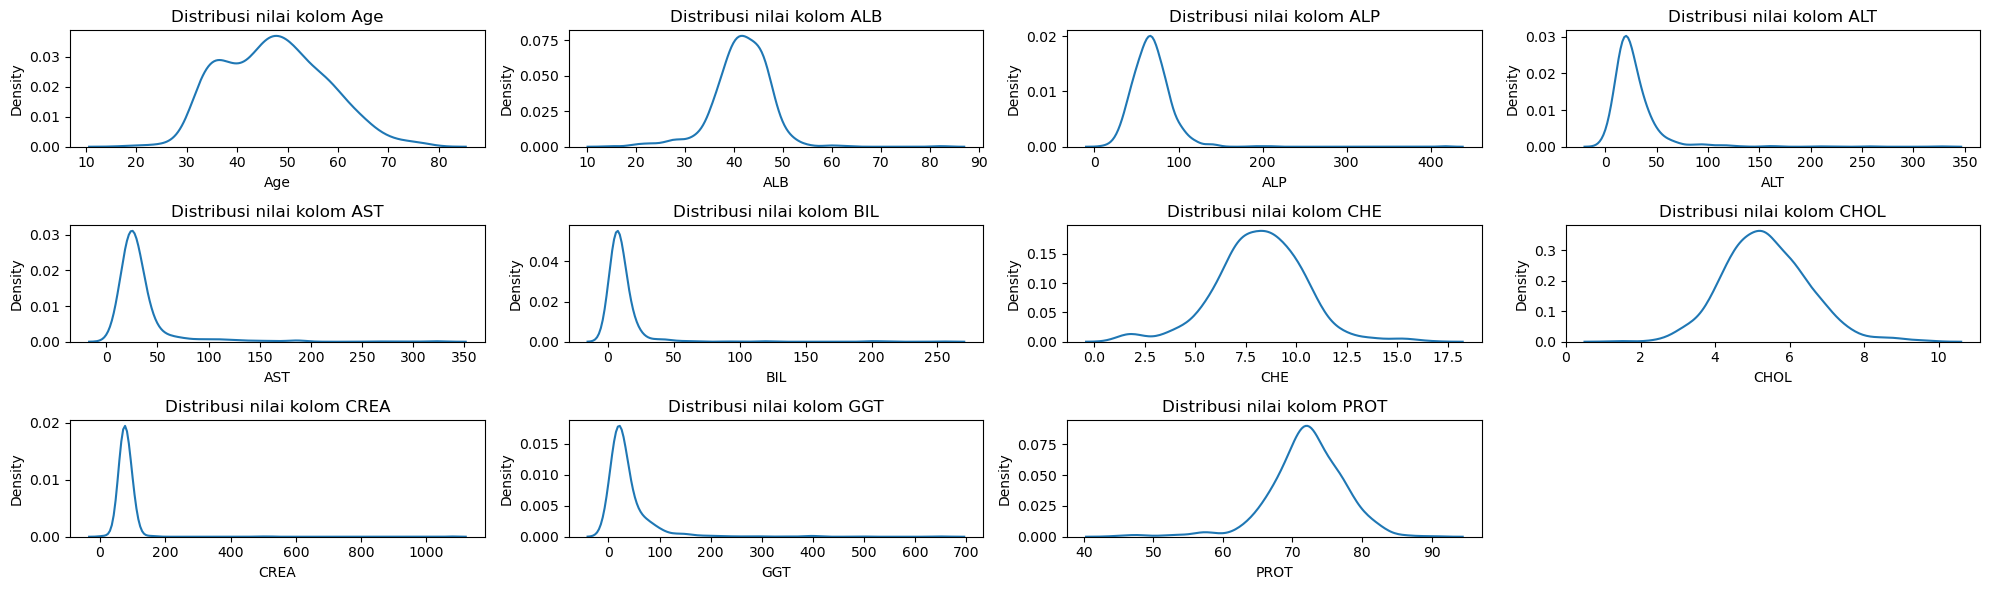

In [8]:
num_rows = 3
num_cols = math.ceil(len(numerical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data, x=column, ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Distribution value for numerical columns based on Gender

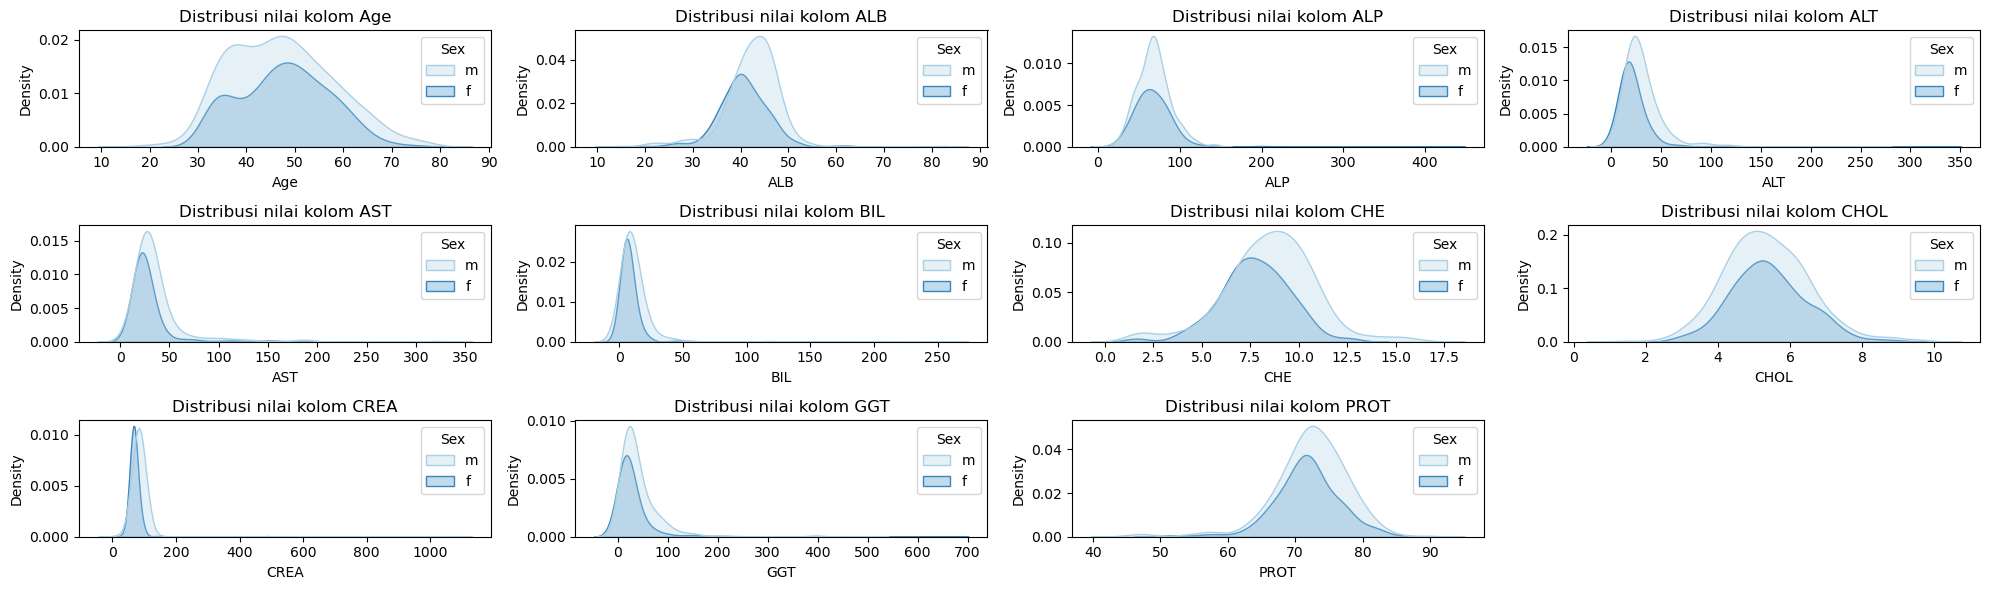

In [9]:
num_rows = 3
num_cols = math.ceil(len(numerical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data, x=column, hue="Sex", fill=True, alpha=.3, palette="Blues", ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

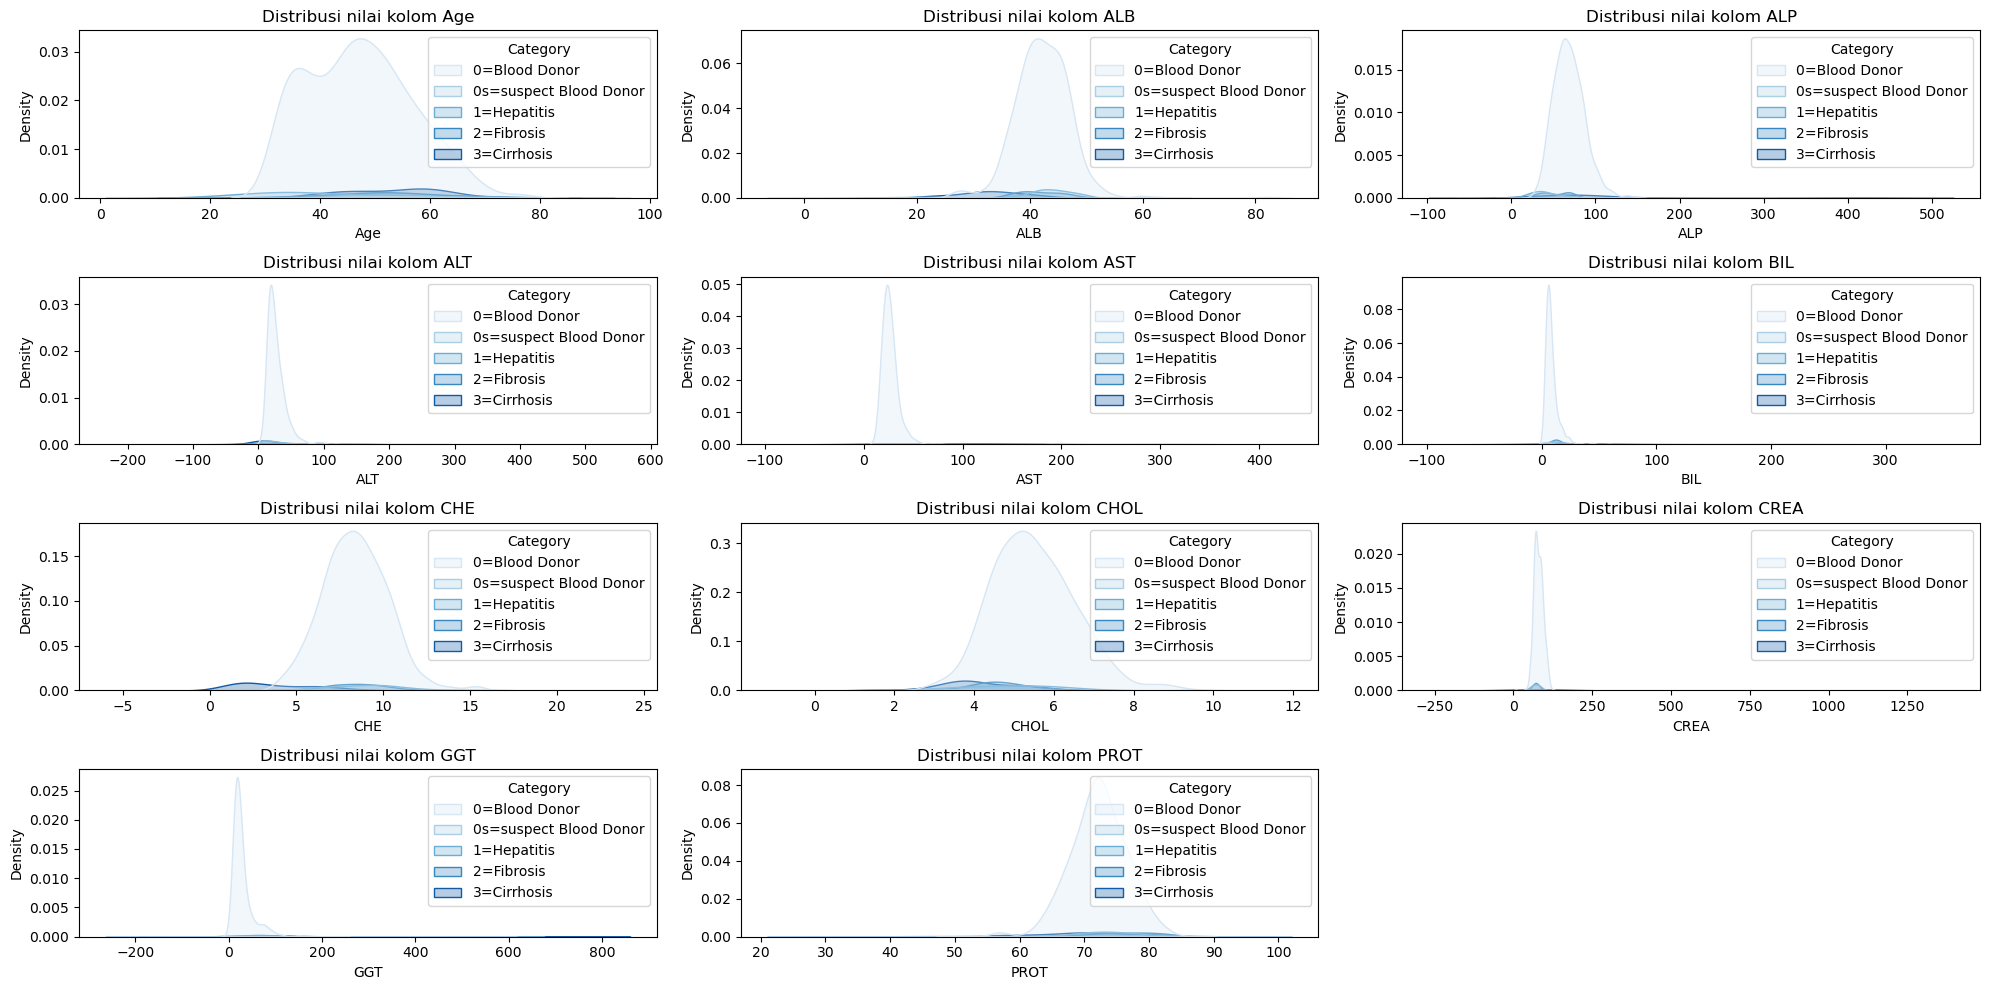

In [58]:
num_rows = 4
num_cols = math.ceil(len(numerical_column) / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data, x=column, hue="Category", fill=True, alpha=.3, palette="Blues", ax=axes[row, col]).set_title("Distribusi nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Count of each value for categorical columns

In [33]:
# num_rows = 1
# num_cols = math.ceil(len(categorical_column) / num_rows)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))
# for i, column in enumerate(categorical_column):
#     row = i // num_cols
#     col = i % num_cols
#     sns.countplot(x=data[column], ax=axes[row, col], palette="Blues").set_title(column)
    
    
# for i in range(len(categorical_column), num_rows * num_cols):
#     row = i // num_cols
#     col = i % num_cols
#     axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

Text(0.5, 1.0, 'Category')

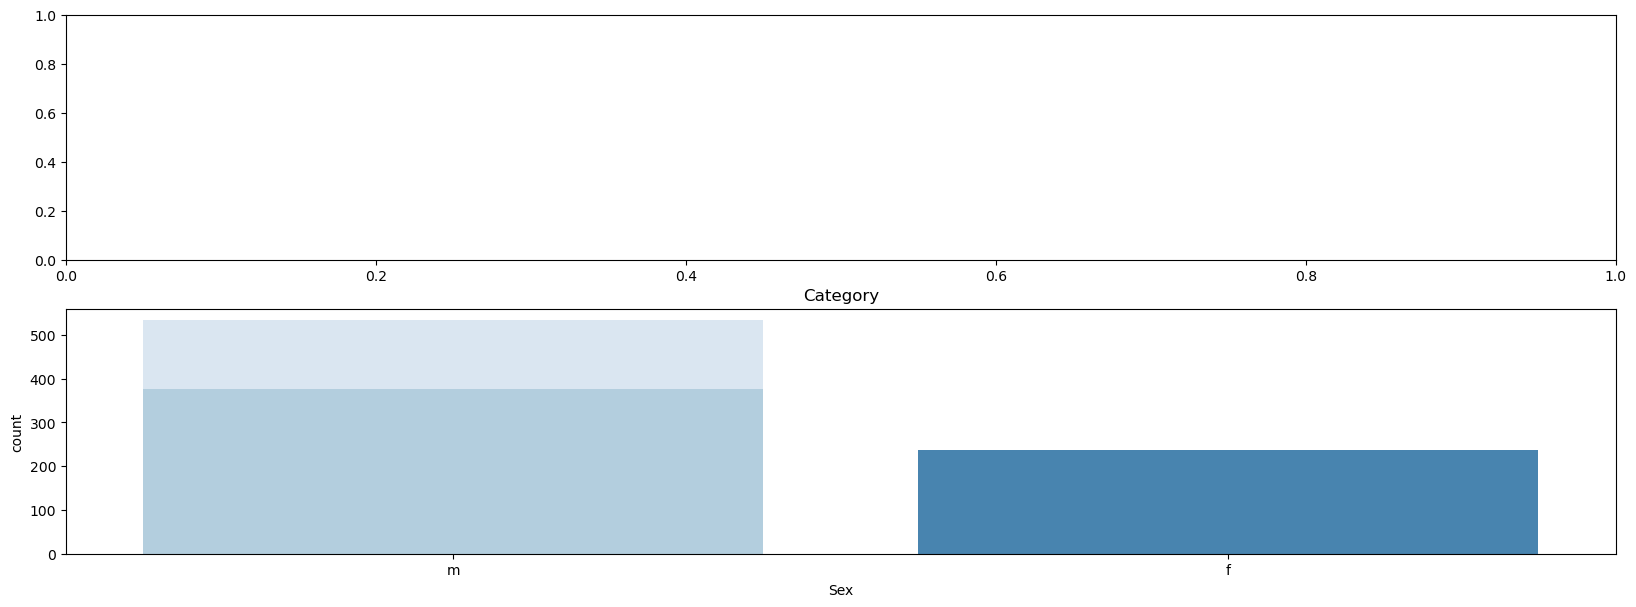

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(20, 7))

sns.countplot(x=data[categorical_column[0]], palette="Blues").set_title(column)
sns.countplot(x=data[categorical_column[1]], palette="Blues").set_title(column)

### The range of values in the numerical column

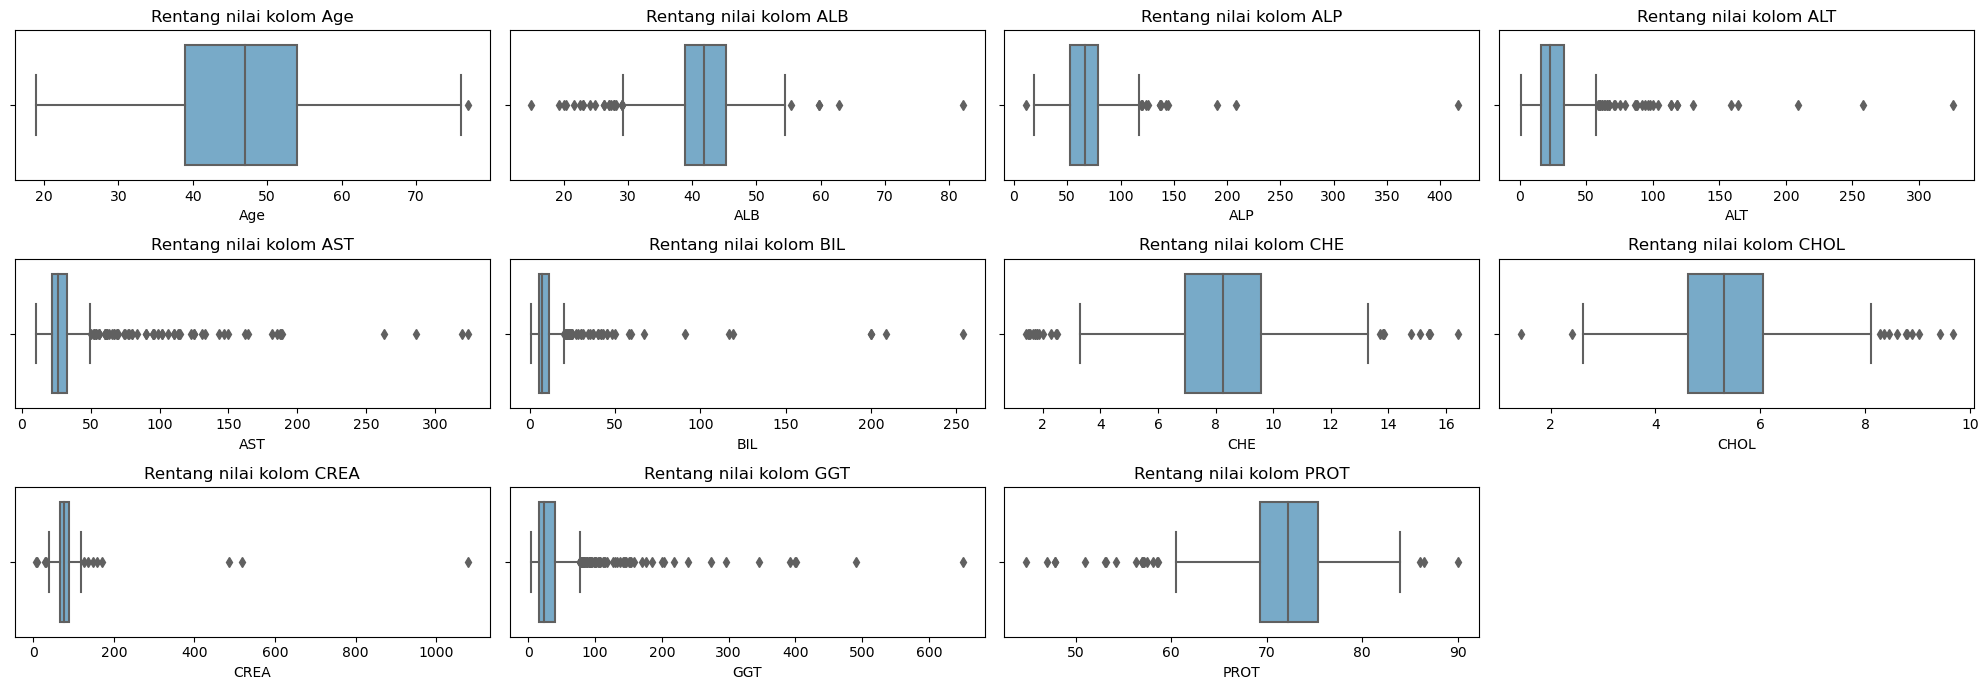

In [10]:
num_rows = 3
num_cols = math.ceil(len(numerical_column) / num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))
for i, column in enumerate(numerical_column):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Blues").set_title("Rentang nilai kolom " + column)
    
for i in range(len(numerical_column), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### The range of values in ALL column

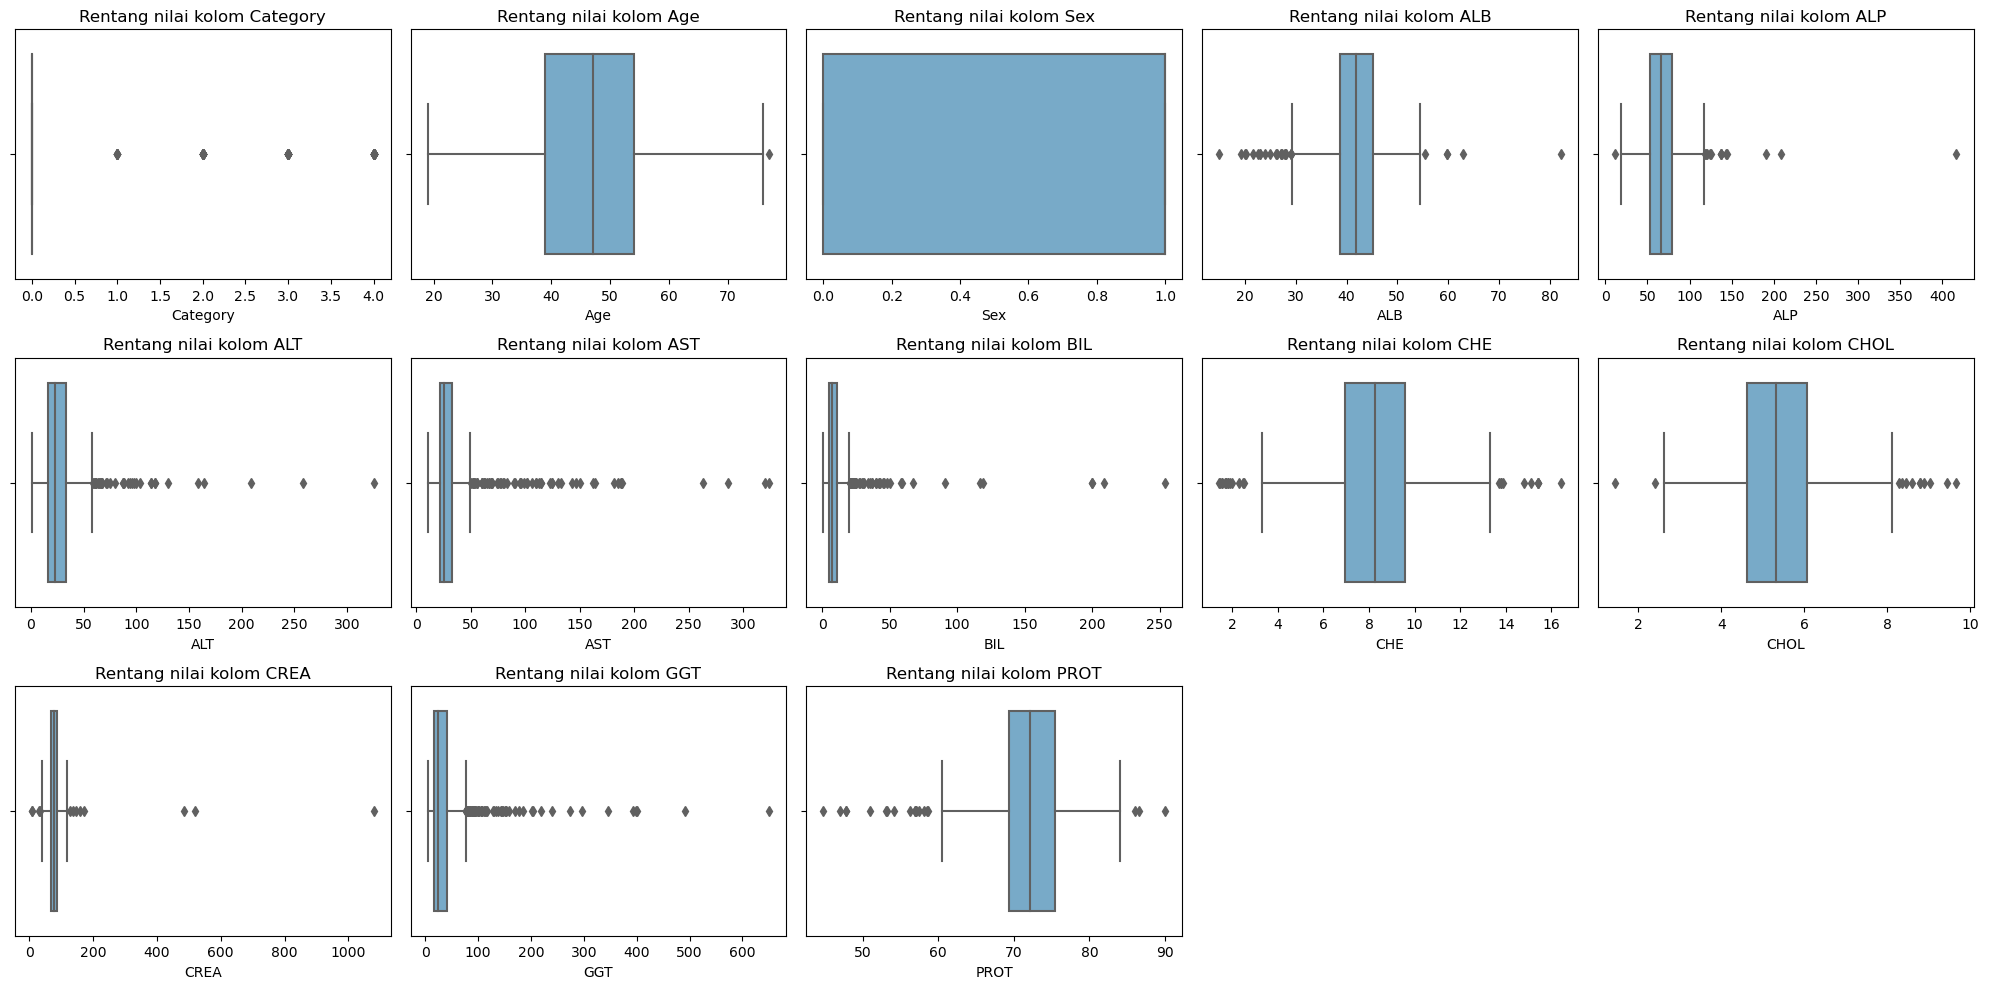

In [14]:
range_data = data.copy()

encoder = LabelEncoder()
for column in categorical_column:
    range_data[column] = encoder.fit_transform(range_data[column])

num_rows = 3
num_cols = math.ceil(len(range_data.columns) / num_rows)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(range_data.columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=range_data[column], ax=axes[row, col], palette="Blues").set_title("Rentang nilai kolom " + column)
    
for i in range(len(range_data.columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Data correlation between columns

<Axes: >

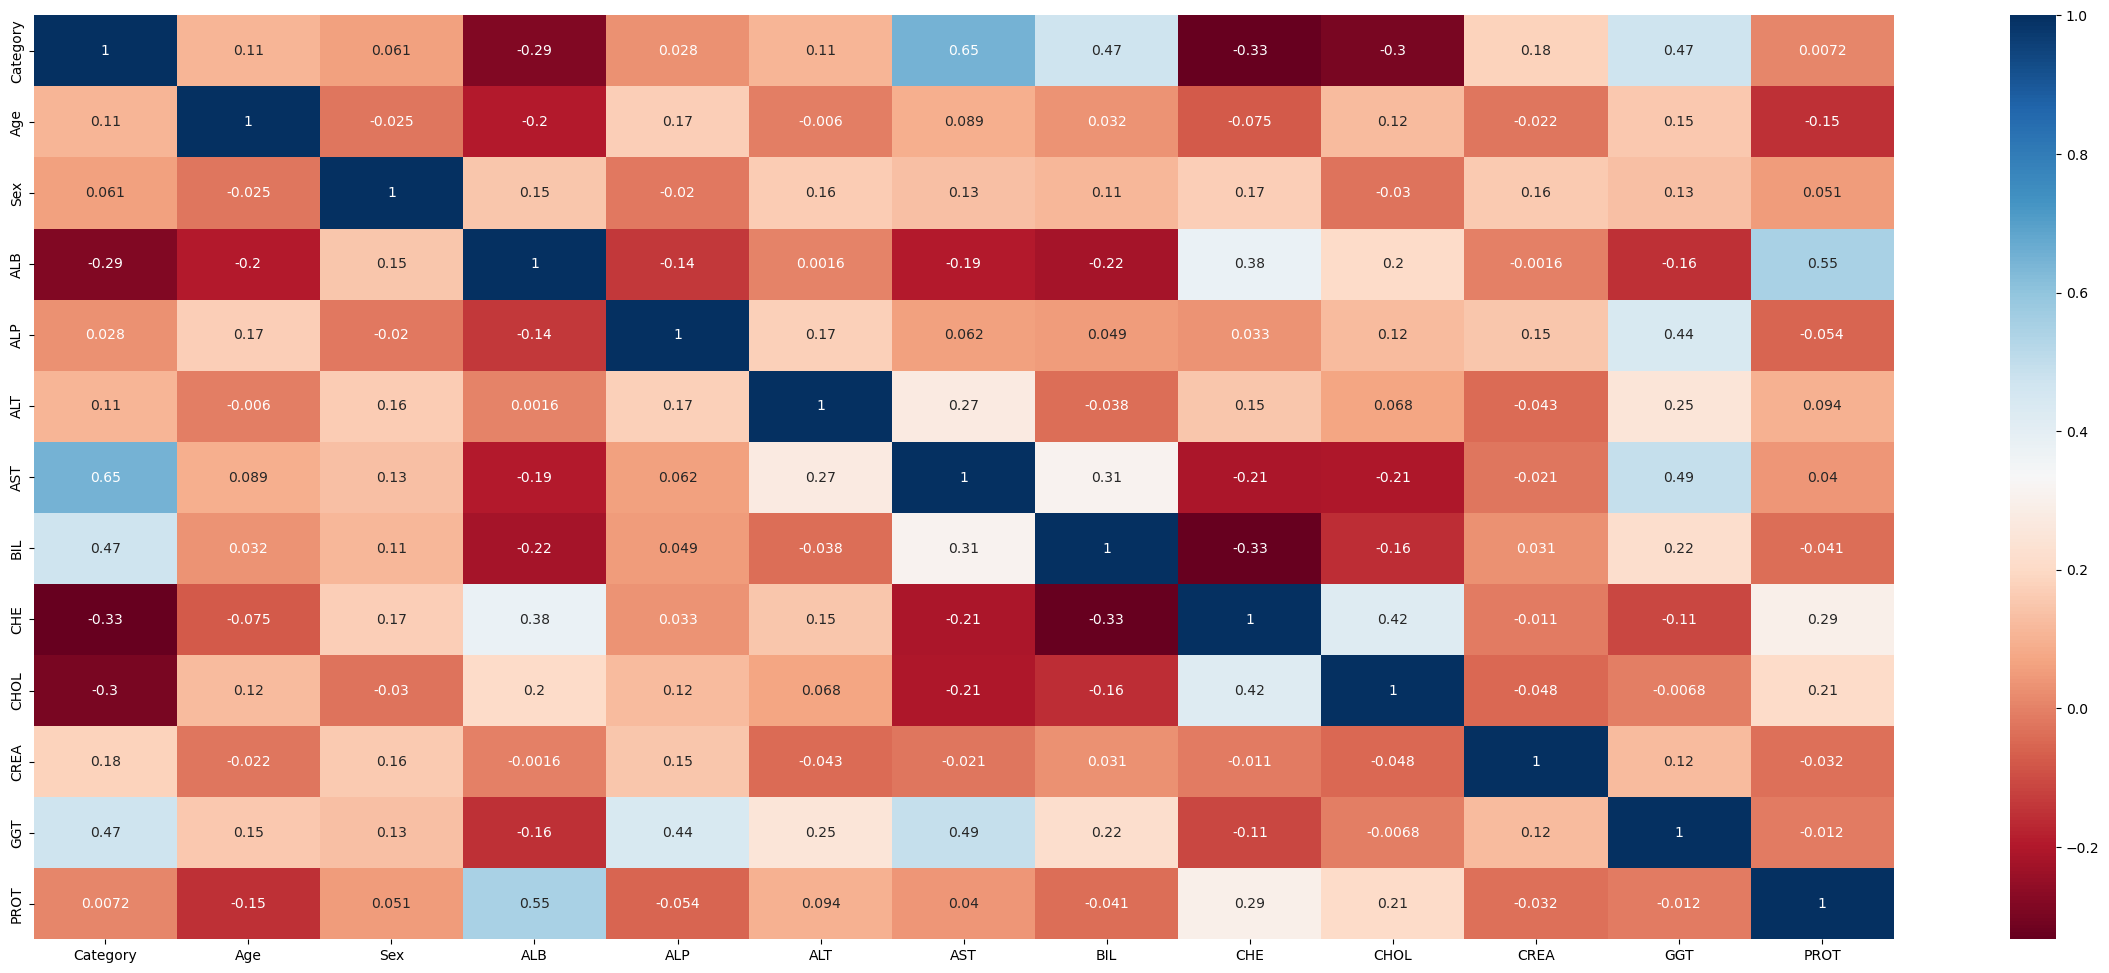

In [6]:
datacorr = data.copy()

encoder = LabelEncoder()
for column in categorical_column:
    datacorr[column] = encoder.fit_transform(datacorr[column])

plt.figure(figsize=(30,12))
corr = datacorr.corr()
sns.heatmap(corr, annot=True, cmap="RdBu")

# Data Preprocessing

In [7]:
encoder = LabelEncoder()
for column in categorical_column:
    data[column] = encoder.fit_transform(data[column])

X = data.drop(columns=['Category'])
Y = data['Category'].astype('int8')

print(Counter(Y))
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
print(Counter(Y))

scaler = MinMaxScaler()
# scaler = StandardScaler()
X = scaler.fit_transform(X)

Counter({0: 533, 4: 30, 2: 24, 3: 21, 1: 7})
Counter({0: 533, 1: 533, 2: 533, 3: 533, 4: 533})


### Split data to Train and Test data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {(X_train.shape)}')
print(f'Total # of sample in test dataset: {(X_test.shape)}')

trans = PowerTransformer()
X_train = trans.fit_transform(X_train)
X_test = trans.transform(X_test)

Total # of sample in whole dataset: 2665
Total # of sample in train dataset: (1865, 12)
Total # of sample in test dataset: (800, 12)


# Model Prediction

### Prepare Model

In [9]:
def algorithms():
    algorithms = [
                    ### Classification ###
                  ('KNN Class', KNeighborsClassifier(n_neighbors=1)),
                  ('Random Forest Class',RandomForestClassifier(max_depth=16, random_state=42)),
                  ('XGB Class', XGBClassifier(n_estimators=48, max_depth=100, learning_rate=.1, objective='binary:logistic')),
        
                    ### Regression ###
                  ('Decision Tree', DecisionTreeRegressor(max_depth=28)),
                  ('Hist Gradient B',HistGradientBoostingRegressor()),
                  ('Gradient Boost Reg', GradientBoostingRegressor(n_estimators=36, learning_rate=0.1, max_depth=50, random_state=42)),
                  ('KNN Reg', KNeighborsRegressor(n_neighbors=2)), 
                  ('MLP', MLPRegressor(hidden_layer_sizes=(1000,), max_iter=100, random_state=42)),
                  ('Nu SVR',NuSVR(C=1, nu=0.3)),
                  ('Random Forrest Reg', RandomForestRegressor(n_estimators=17, max_depth=50, random_state=42)),
                  ('SVR', SVR(kernel='rbf')), 
                  ]
    return algorithms

def prepare_model(algorithm):
    model = algorithm
    model.fit(X_train, y_train)
    return model

def calculate_performance(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = round(model.score(X_train,y_train), 4)*100
    mse = round(mean_squared_error(y_test, y_pred), 2)
    r2  = round(r2_score(y_test, y_pred), 2)
    return acc, mse, r2

def regression_result(result, name, acc, mse, r2):
    result.append((name, acc, mse, r2))
    return result

### Training and Evaluate the model

In [10]:
%%time
result = []
trained_models = []

algorithms = algorithms()

for index, tup in tqdm(enumerate(algorithms)):
    model = prepare_model(tup[1])
    trained_models.append((tup[0],model))

    # Calculate the Accuracy, Mean Squared Error (MSE), and R-squared score
    acc, mse, r2= calculate_performance(model,X_train, y_train, X_test, y_test)
    result = regression_result(result, tup[0], acc, r2, mse)

regression_results_df = pd.DataFrame(result, columns=('Model Name', 'Accuracy', 'R-Square', 'MSE'))
regression_results_df.sort_values(by=['R-Square', 'Accuracy'], ascending=False)

11it [00:05,  2.14it/s]

CPU times: total: 15.5 s
Wall time: 5.15 s


,Model Name,Accuracy,R-Square,MSE
1,Random Forest Class,100.00,0.99,0.02
2,XGB Class,100.00,0.98,0.04
7,MLP,98.98,0.97,0.06
0,KNN Class,100.00,0.96,0.08
4,Hist Gradient B,99.74,0.96,0.07
6,KNN Reg,99.65,0.96,0.09
9,Random Forrest Reg,99.38,0.96,0.07
10,SVR,97.14,0.96,0.09
8,Nu SVR,97.01,0.96,0.09
3,Decision Tree,100.00,0.95,0.09


### Find optimal hyperparameter for some models

100%|██████████| 10/10 [00:00<00:00, 1331.06it/s]

0.707
1


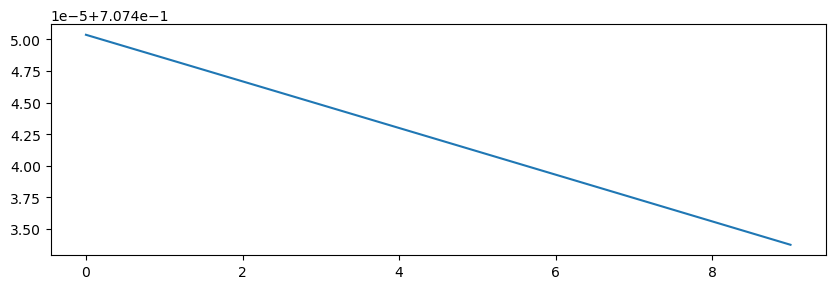

In [91]:
plot_r2 = []

max_value = 0
num_value = 0

start_num = 1
n_number = 10

for i in tqdm(range(start_num, n_number+1)):
    

    ### Classification ###
    # model = AdaBoostClassifier(n_estimators=i, learning_rate=0.1, random_state=42)
    # model = GradientBoostingClassifier(n_estimators=i, learning_rate=0.1, max_depth=50, random_state=42)
    # model = KNeighborsClassifier(n_neighbors=i)
    # model = LinearSVC(random_state=42, tol=(i)/10)
    # model = RandomForestClassifier(max_depth=i, random_state=42)
    # model = SGDClassifier(max_iter=i,loss='hinge', penalty='l2', alpha=1e-3, random_state=42,  tol=None)
    # model = XGBClassifier(n_estimators=i, max_depth=100, learning_rate=.1, objective='binary:logistic')
    
    ### Regression ###
    # model = AdaBoostRegressor( n_estimators=i, random_state=42)
    # model = DecisionTreeRegressor(max_depth=i)
    # model = GradientBoostingRegressor(n_estimators=i, learning_rate=0.1, max_depth=50, random_state=42)
    # model = KernelRidge(alpha=(i)/1000)
    # model = KNeighborsRegressor(n_neighbors=i)
    # model = Lars(n_nonzero_coefs=i)
    # model = LarsCV(cv=i)
    # model = Lasso(alpha=(i)/100)
    # model = LassoCV(cv=i, random_state=42)
    # model = LassoLars(alpha=(i)/1000)
    # model = LassoLarsCV(cv=i)
    # model = LogisticRegressionCV(cv=i, random_state=42)
    # model = LinearSVR(random_state=42, tol=(i)/1000)
    # model = NuSVR(C=1, nu=(i)/10)
    # model = OrthogonalMatchingPursuitCV(cv=i)
    # model = PassiveAggressiveRegressor(max_iter=i, random_state=42, tol=1e-1)
    # model = RandomForestRegressor(n_estimators=i, max_depth=100, random_state=42)
    # model = Ridge(alpha=(i)/10)
    # model = SGDRegressor(max_iter=i, tol=1e-4, random_state=42)
    # model = TweedieRegressor(power = i)
    
    model.fit(X_train, y_train)
    # Calculate the R-squared score
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    plot_r2.append(r2)
    if (round(r2, 3)> max_value):
        max_value = round(r2, 3)
        num_value = i
    
print(max_value)
print(num_value)

plt.figure(figsize=(10,3))
plt.plot(plot_r2)
plt.show()